In [8]:
import numpy as np
import pandas as pd
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.formula.api import glm
import collections
from statsmodels.sandbox.stats.multicomp import multipletests

#import folium # package for making maps, please make sure to use a version older than 1.0..



Leer la base de datos, unir latitud y longitud en una sola columna

In [9]:
df=pd.read_csv('Final_Final.csv')
lights=pd.read_csv('lights_clean.csv')
list_df=[]
x_df=[]
y_df=[]
for i in range(df.shape[0]):
    #address=str(round(df['LATITUD'].iloc[i],7))+' '+str(round(df['LONGITUD'].iloc[i],7))
    address=str(df['LATITUD'].iloc[i])+' '+str(df['LONGITUD'].iloc[i])
    list_df.append(address)   
    
df['LAT_LON']=list_df
df['ID']=df['BUS_SUBIDA']


newdf=df[['LAT_LON','ID','BUS_SUBIDA','BUS_BAJADA','TRAFICO','POT','PIEZA_URBANA','LATITUD','LONGITUD']]

Contar la cantidad de accidentes y armar la nueva tabla.

Revisar que las direcciones sean parecidas y dejar solo aquellas intersecciones donde el número de direcciones distintas sea grande. 
``counter=collections.Counter(a)``

``if counter.most_common(1)[0][1]/a.size>0.3:``

In [10]:
dff=newdf.groupby(['LAT_LON']).count().reset_index()
list_accidents=[]
list_df=[]
for i in range(dff.shape[0]):
    a=df[df['LAT_LON']==dff["LAT_LON"][i]]['SITIO_EXACTO_ACCIDENTE']
    counter=collections.Counter(a)
    if counter.most_common(1)[0][1]/a.size>0.3:
        list_df.append(np.array(newdf[newdf['LAT_LON']==dff['LAT_LON'].iloc[i]]).tolist()[0])
        list_accidents.append(dff['ID'][i])
        
final_df = pd.DataFrame.from_records(list_df)
final_df=final_df.rename(columns={0:'LAT_LON',1:'ID',2:'BUS_SUBIDA',3:'BUS_BAJADA',4:'TRAFICO',5:'POT',6:'PIEZA_URBANA',7:'LATITUD',8:'LONGITUD'})
final_df['ID']=list_accidents

Crear la matriz de distancias y de número de semáforos cerca

In [ ]:
closest=np.zeros(final_df.shape[0])
numclose=np.zeros(final_df.shape[0])
numclose2=np.zeros(final_df.shape[0])
numclose3=np.zeros(final_df.shape[0])
for i in range(final_df.shape[0]):
    corner_lat=final_df['LATITUD'][i]
    corner_lon=final_df['LONGITUD'][i]
    light_lat=np.array(lights['LATITUD'])
    light_lon=np.array(lights['LONGITUD'])
    dx = (light_lon-corner_lon)*40000*np.cos((light_lat+corner_lat)*math.pi/360)/360
    dy = (light_lat-corner_lat)*40000/360
    distance=np.sqrt(dx**2+dy**2)
    closest[i]=distance[distance.argmin()]
    numclose[i]=sum(distance<0.1)
    numclose2[i]=sum(((distance>=0.1) & (distance<0.5)))
    numclose3[i]=sum(((distance>=0.5) & (distance<2)))
final_df['NLIGHTS']=list(numclose)
final_df['NLIGHTS2']=list(numclose2)
final_df['NLIGHTS3']=list(numclose3)

final_df['CLOSEST_LIGHT']=list(closest)
data=final_df.rename(columns={'ID':'NACCIDENTS'})

Modelo inicial

In [5]:
formula='NACCIDENTS~BUS_SUBIDA+BUS_BAJADA+POT+PIEZA_URBANA+NLIGHTS+NLIGHTS2+TRAFICO+CLOSEST_LIGHT'
mod1 = glm(formula=formula, data=data, family=sm.families.Poisson()).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             NACCIDENTS   No. Observations:                 5830
Model:                            GLM   Df Residuals:                     5809
Model Family:                 Poisson   Df Model:                           20
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20040.
Date:                Wed, 27 Nov 2019   Deviance:                       25217.
Time:                        11:49:49   Pearson chi2:                 5.05e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                1.2876      0.042     30.387      0.000       1.205       1.371
POT[T.comercial]                         0.0966      0.029      3.285      0.001       0.039       0.154
POT[T.industrial]                        0.4099      0.044      9.332      0.000       0.324       0.496
POT[T.ninguna]                          -0.0892      0.033     -2.672      0.008      -0.155      -0.024
POT[T.portuaria]                        -0.6026      0.099     -6.065      0.000      -0.797      -0.408
POT[T.protegida]                        -0.0911      0.047     -1.921      0.055      -0.184       0.002
POT[T.residencial]                      -0.2794      0.032     -8.851      0.000      -0.341      -0.218
PIEZA_URBANA[T.centro metropolitana]    -0.1036      0.036     -2.878      0.004      -0.174      -0.033
PIEZA_URBANA[T.ninguna]                  0.2247      0.064      3.492      0.000       0.099       0.351
PIEZA_URBANA[T.prado norte]             -0.0442      0.031     -1.405      0.160      -0.106       0.017
PIEZA_URBANA[T.ribera occidental]        0.3705      0.043      8.571      0.000       0.286       0.455
PIEZA_URBANA[T.riomar]                   0.2670      0.027      9.886      0.000       0.214       0.320
PIEZA_URBANA[T.suroccidental 1]         -0.1777      0.039     -4.606      0.000      -0.253      -0.102
PIEZA_URBANA[T.suroccidental 2]          0.0907      0.040      2.258      0.024       0.012       0.169
PIEZA_URBANA[T.suroriental]              0.0809      0.028      2.843      0.004       0.025       0.137
BUS_SUBIDA                              -0.1069      0.010    -10.806      0.000      -0.126      -0.088
BUS_BAJADA                               0.0722      0.010      7.051      0.000       0.052       0.092
NLIGHTS                                  0.1525      0.013     11.489      0.000       0.126       0.178
NLIGHTS2                                -0.0185      0.002     -8.266      0.000      -0.023      -0.014
TRAFICO                                  0.0441      0.038      1.153      0.249      -0.031       0.119
CLOSEST_LIGHT                           -0.0477      0.017     -2.738      0.006      -0.082      -0.014
========================================================================================================
"""

Corregir pvalores por Bonferroni y mostrar los NO significativos

In [6]:
p_adjusted = multipletests(mod1.pvalues, alpha=0.05, method='bonferroni')
mod1.params[p_adjusted[1]>0.05]

POT[T.ninguna]                         -0.089228
POT[T.protegida]                       -0.091107
PIEZA_URBANA[T.centro metropolitana]   -0.103631
PIEZA_URBANA[T.prado norte]            -0.044184
PIEZA_URBANA[T.suroccidental 2]         0.090728
PIEZA_URBANA[T.suroriental]             0.080913
TRAFICO                                 0.044091
CLOSEST_LIGHT                          -0.047729
dtype: float64

Modelo eliminando variables ``TRAFICO`` y ``CLOSEST_LIGHT``

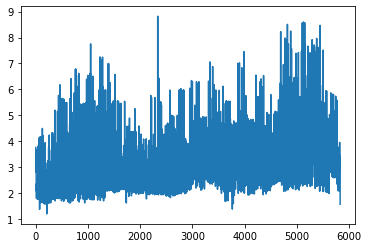

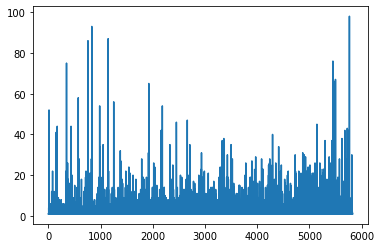

In [7]:
formula2='NACCIDENTS~BUS_SUBIDA+BUS_BAJADA+POT+PIEZA_URBANA+NLIGHTS+NLIGHTS2'
mod2 = glm(formula=formula, data=data, family=sm.families.Poisson()).fit()

mod2.predict()
plt.plot(list(mod2.predict()))
plt.show()
plt.plot(data['NACCIDENTS'])
plt.show()